In [1]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [2]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [3]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


## 1. DataFrame 생성

In [4]:
irisdf=spark.createDataFrame(iris[['petal_length','petal_width']])

In [5]:
irisdf.printSchema()

root
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)



## 2. 데이터와 회귀선 그래프

In [6]:
import numpy as np
x = np.array([iris['petal_length'], np.ones(150)])
y = np.array(iris['petal_width'])

In [7]:
print(x.shape)
print(y.shape)
w0, w1=np.linalg.lstsq(x.T, y, rcond=None)[0]
print ("w0: {}\nw1: {}".format(w0, w1))

(2, 150)
(150,)
w0: 0.4164191322854012
w1: -0.3665140452167269


In [8]:
yhat=w0*x[0]+w1


Bad key "text.kerning_factor" on line 4 in
C:\Users\woojung\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


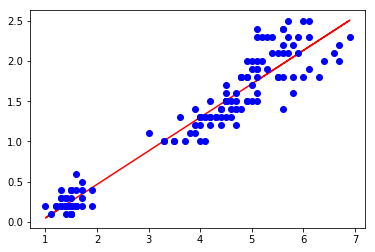

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x[0],yhat,'r-',x[0],y,'bo')
plt.show()

## 3. Spark를 사용하여 회귀분석하고 계수 출력

In [10]:
(trainDf, testDf) = irisdf.randomSplit([0.6, 0.4])

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

va = VectorAssembler(inputCols = ["petal_length"], outputCol = 'features')
lr = LinearRegression(featuresCol = 'features', labelCol='petal_width', maxIter=10, regParam=0.0, elasticNetParam=0.0)

## 파라미터 값의 변화를 주면서 학습한 결과 regParam과 elasticNetParam의 값이 0일때 가장 좋은 성능을 보임

In [12]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[va, lr])

In [13]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

In [14]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept))

Coefficients: [0.42937087313975264]
Intercept: -0.392


## 4. 실제와 예측 출력

In [15]:
modelTestDf=model.transform(testDf)

In [16]:
modelTestDf.select('petal_width','prediction').show(10)

+-----------+-------------------+
|petal_width|         prediction|
+-----------+-------------------+
|        0.2| 0.1664269074011514|
|        0.3| 0.1664269074011514|
|        0.3| 0.1664269074011514|
|        0.4| 0.1664269074011514|
|        0.2|0.20936399471512657|
|        0.2|0.20936399471512657|
|        0.2|0.20936399471512657|
|        0.3|0.20936399471512657|
|        0.1|0.25230108202910195|
|        0.2|0.25230108202910195|
+-----------+-------------------+
only showing top 10 rows



## 5. 정확성 평가

In [17]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="rmse")

In [18]:
rmse=evaluator.evaluate(modelTestDf)
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

'Root Mean Squared Error (RMSE) on test data: 0.223'

In [19]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_width", predictionCol="prediction", metricName="r2")

In [20]:
f"r2: {evaluator.evaluate(modelTestDf):.3f}"

'r2: 0.909'